<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project1_numerical_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1: Diffusion equation

In this project we will use several methods to solve the diffusion equation:

$$ \partial_t c = \kappa \partial_x^2 c $$

This project consists of two notebooks. First, in this notebook, we will solve this equation using second order finite differences to approximate the $x$-derivatives, and we will use both the explict Euler and Crank-Nicolson timestepping methods.

In the second notebook for this project, we will learn how to use Dedalus to solve the same problem using spectral methods.

The objective for this notebook is learn about spatial discretization and to compare the stability, accuracy, and speed of the Explicit euler and Crank-Nicolson methods when applied to the diffusion equation.

Student tasks are in [Section 2.1](#section2pt1) and [Section 2.2](#section2pt2).

Before we start, load in the required libraries

In [2]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import time


Now, define two functions to timestep the diffusion equation. The code below timesteps the diffusion equation using the expicit Euler method. The function takes in a vector of discrete positions, `x`, discrete times, `t`, and the diffusivity, `kappa`. The vectors `x` and `t` dictate the discretization of the problem in space and time, and the grid spacing must be constant in space and time. The boundary conditions are $\partial_x c=0$ at the starting and ending points in `x`.

In [3]:
def EE(x, t, kappa):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler and second order finite difference methods

    start_time = time.time()  # Start a timer

    # Infer the uniform grid spacing:
    dx = (x[-1] - x[0]) / (len(x) - 1); dt = (t[-1] - t[0]) / (len(t) - 1)

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    # Builds a coefficient matrix, such that M*c is the discrete version of d/dx(c)
    M = (np.diag(np.ones(Nx-1), -1) - 2*np.diag(np.ones(Nx), 0) + np.diag(np.ones(Nx-1), 1)) / dx**2

    # Turn M into a sparse matrix to save memory and improve speed
    M = sp.csr_matrix(M)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt):  # loop over the number of timesteps
      c[:,k] = c[:,k-1] + dt * kappa * M @ c[:,k-1]
      # Enforce the boundary conditions (no flux)
      c[0, k] = c[1, k]
      c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    print(f"Explicit Euler method took {end_time - start_time:.2f} seconds")

    return c

Similarly, the function below timesteps the diffusion equation with the Crank-Nicolson method

In [4]:
def CN(x, t, kappa):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler and second order finite difference methods
    start_time = time.time()  # Start a timer

    # Infer the uniform grid spacing:
    dx = (x[-1] - x[0]) / (len(x) - 1); dt = (t[-1] - t[0]) / (len(t) - 1)

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    # build a coefficient matrix, such that M*c is the discrete version of d/dx(c)
    M = (np.diag(np.ones(Nx-1), -1) - 2*np.diag(np.ones(Nx), 0) + np.diag(np.ones(Nx-1), 1)) / dx**2

    # Turn M into a sparse matrix to save memory and improve speed:
    M = sp.csr_matrix(M)

    A = sp.eye(Nx) - 0.5 * dt * kappa * M  # This matrix appears on the LHS in the C-N scheme
    A_inv = spla.inv(A) # Calculate the inverse of A (this only needs to be done once)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt): # loop over the number of timesteps
        c[:, k] = A_inv @ (c[:, k-1] + 0.5 * dt * kappa * (M @ c[:, k-1]))
        # Enforce the boundary conditions
        c[0, k] = c[1, k]
        c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    print(f"Crank-Nicolson method took {end_time - start_time:.2f} seconds")

    return c

Next, create a function to set the initial conditions. The exact solution to the unbounded diffusion equation with a delta function initial condition is:

$$\left(\frac{1}{4\pi\kappa t}\right)^{1/2}e^{-x^2/(4\kappa t)}$$

The function below sets the initial condition by evaluating the exact solution at a given time. Note that it is important that we don't evaluate the exact solution at `t_ic=0` since this will return a delta function which will be undefined on our finite grid. The value of `t_ic` is set within the `EE` and `CN` functions.

In [5]:
# Function to set the initial condition from the exact solution at time t_start
def set_ics(x, kappa, t_ic):
    c_ic = (4*np.pi*kappa*t_ic)**(-0.5)*np.exp(-x**2 / (4*kappa*t_ic))
    # Enforce the boundary conditions
    c_ic[0] = c_ic[1]
    c_ic[-1] = c_ic[-2]
    return c_ic


Finally, define some parameters and the x and t vectors:

In [6]:
# Defining parameters
kappa = 0.001  # diffusivity

# Timestepping parameters
t_start = 0  # start time (note that this is not the same time used to evaluate the exact solution to set the ICs)
t_end = 10  # end time
Nt = 1000  # number of timesteps

# Size of the physical domain
x_start = -1
x_end = 1
Nx = 100

t = np.linspace(t_start, t_end, Nt)  # Create a vector of times
x = np.linspace(x_start, x_end, Nx)  # Create a vector for x

Run each method once:

In [7]:
# Run the simulations
c_EE = EE(x, t, kappa) # explicit Euler
c_CN = CN(x, t, kappa) # Crank-Nicolson

Explicit Euler method took 0.25 seconds


/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_matfuncs.py:76: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  Ainv = spsolve(A, I)


Crank-Nicolson method took 0.27 seconds


and finally, plot the results side-by-side

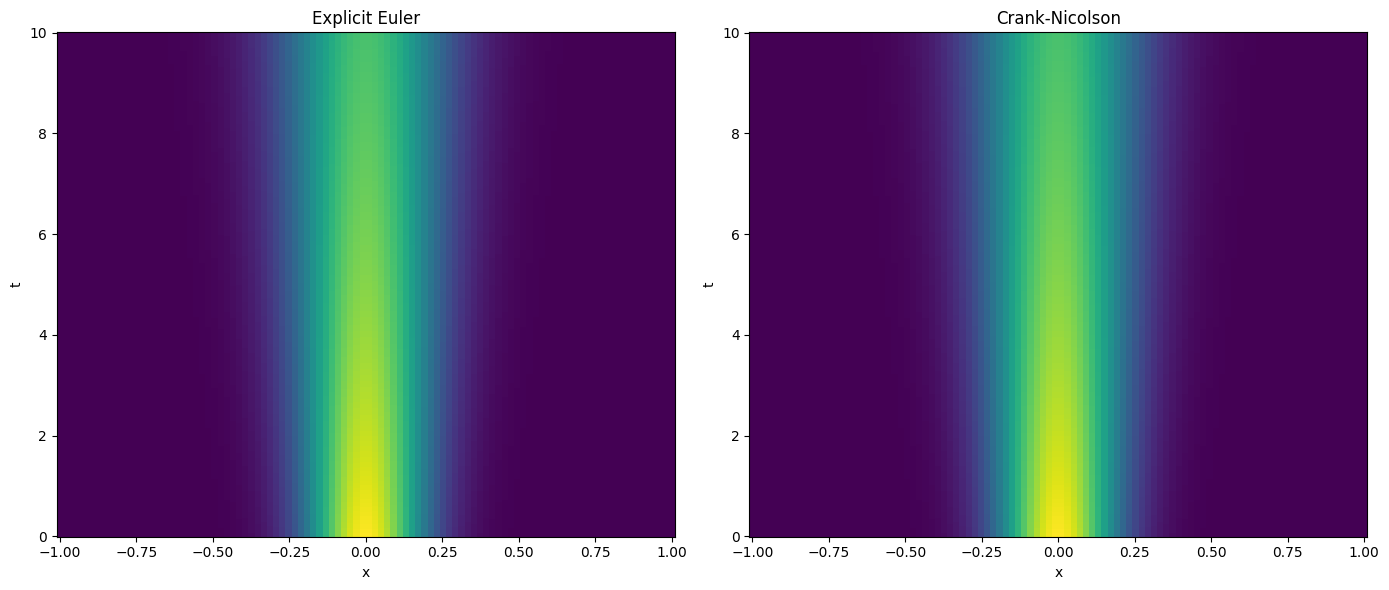

In [8]:
# Plot the results
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.pcolormesh(x, t, c_EE.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Explicit Euler')

plt.subplot(1, 2, 2)
plt.pcolormesh(x, t, c_CN.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Crank-Nicolson')

plt.tight_layout()
plt.show()

## 2. Student investigation

### 2.1 Stability
<a id='section2pt1'></a>
The explicit Euler and Crank-Nicolson methods have very different stability properties. To explore this, try increasing Nx (decreasing the grid spacing, $\Delta x$) and/or increase the diffusivity, $\kappa$, and see how each method responds. How does the stability depend on `Nx`? Discuss your findings below (~1 paragraph)

I set three different values for $\kappa$ and $Nx$ ($\kappa = 0.001, 0.01, 0.1$; $N_x = 50, 100, 200$) and used nested 'for loops' to plot the results for each combination of $\kappa$ and $Nx$. From the figures below, I observed that for the Explicit Euler method, increasing $\kappa$ while keeping $Nx$ constant leads to instability. Specifically:

- When $\kappa = 0.001$, the Explicit Euler method is stable for all the $Nx$ values I tested.  
- For $\kappa = 0.01$, the method is stable when $Nx = 50$ or $Nx = 100$, but it becomes unstable when $Nx = 200$.  
- When $\kappa = 0.1$, the Explicit Euler method is unstable for all the $Nx$ values I selected.

In contrast, the Crank-Nicolson method exhibits much more robust stability properties. Even as $Nx$ is increased or $\kappa$ becomes larger, the Crank-Nicolson method remains stable due to its implicit nature.

Another observation from the figures is that when $Nx$ is small, the output displays noticeable pixelation, whereas for larger $Nx$, the figures appear smoother. This likely indicates that simulations with larger $Nx$ better capture the diffusion process compared to those with smaller $Nx$.

Regarding the visualization of instability, I noticed two distinct patterns. One pattern shows "blank" areas in the figure, which may indicate the presence of NaN values. The other pattern appears uniformly green, which might suggest that the method produces the same value that do not converge.

In conclusion, the Explicit Euler method's stability is highly sensitive to increases in $N_x$ and $\kappa$, while the Crank-Nicolson method remains stable under these changes due to its semi-implicit nature.


Running simulation with kappa = 0.001, Nx = 50
Explicit Euler method took 0.16 seconds
Crank-Nicolson method took 0.07 seconds


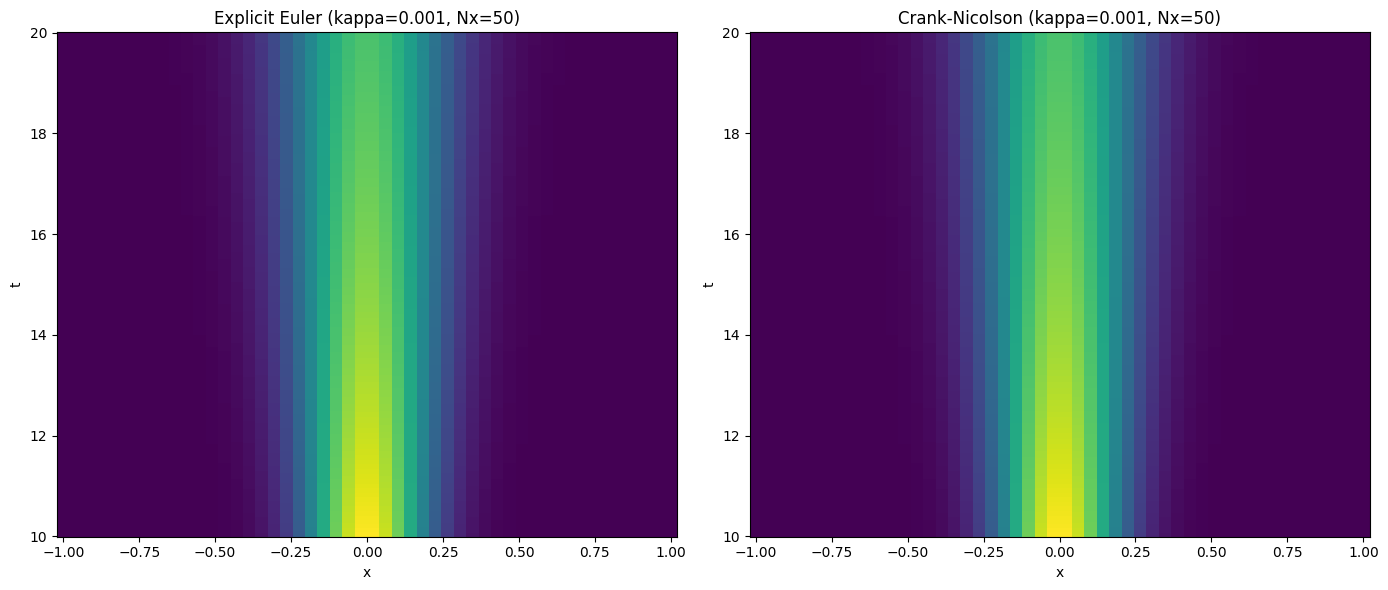

Running simulation with kappa = 0.001, Nx = 100
Explicit Euler method took 0.07 seconds
Crank-Nicolson method took 0.05 seconds


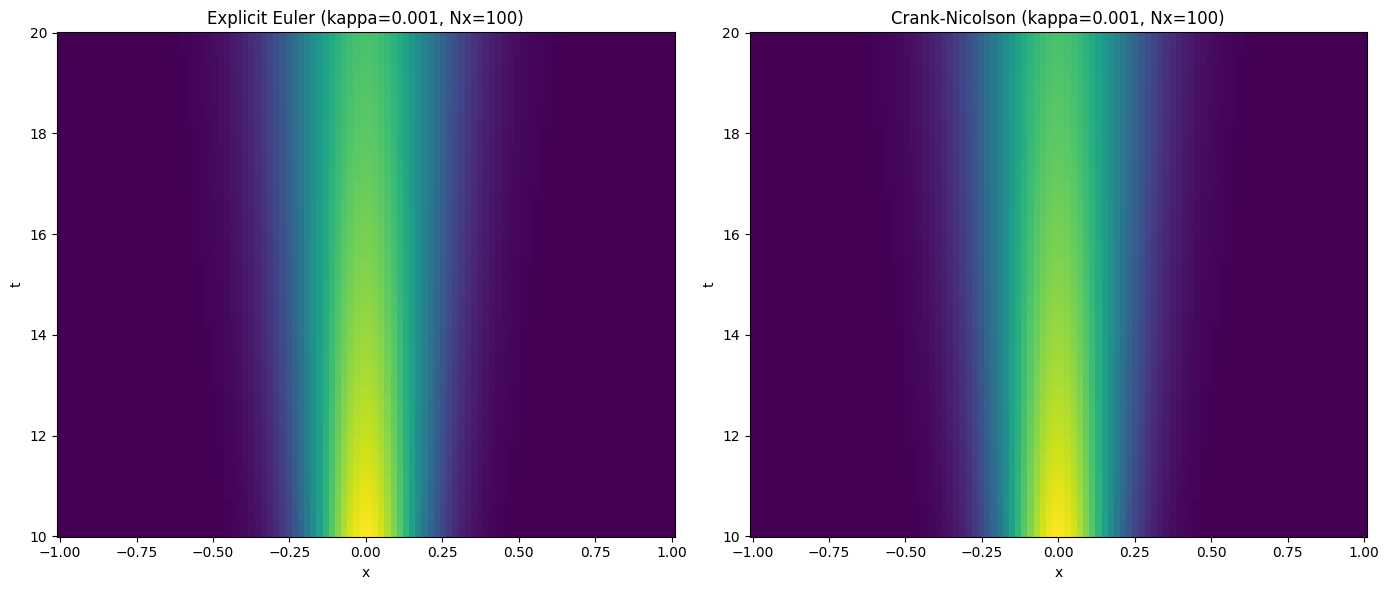

Running simulation with kappa = 0.001, Nx = 200
Explicit Euler method took 0.08 seconds
Crank-Nicolson method took 0.14 seconds


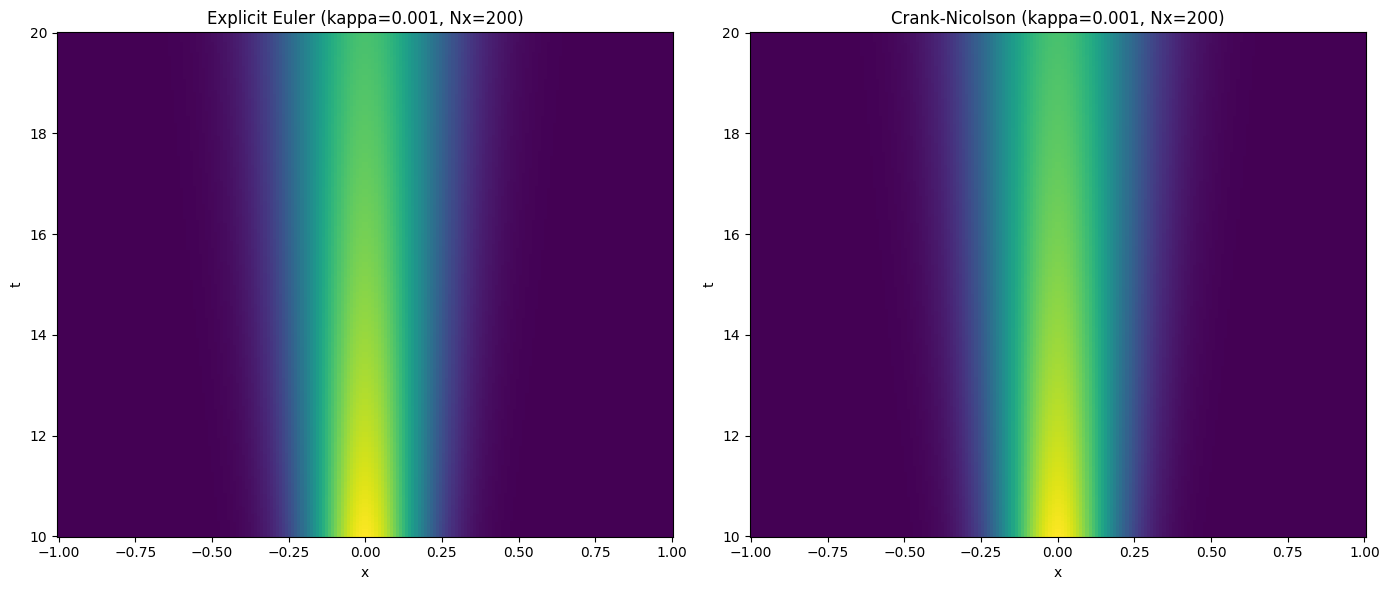

Running simulation with kappa = 0.01, Nx = 50
Explicit Euler method took 0.07 seconds
Crank-Nicolson method took 0.04 seconds


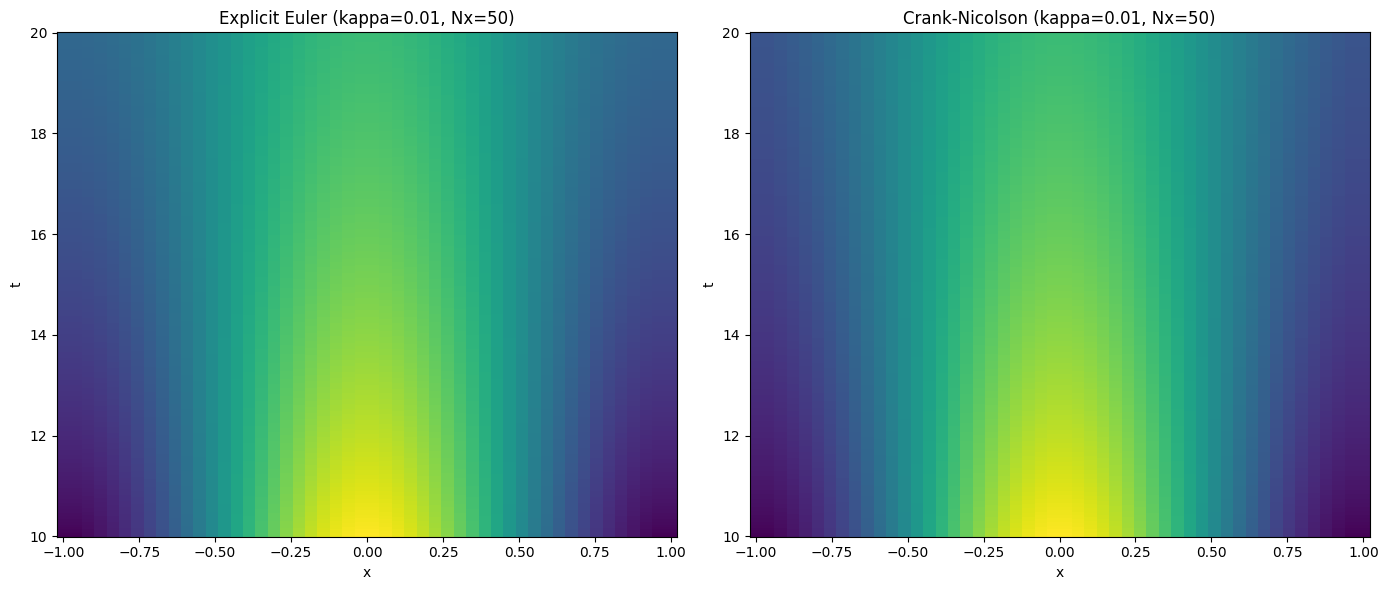

Running simulation with kappa = 0.01, Nx = 100
Explicit Euler method took 0.09 seconds
Crank-Nicolson method took 0.10 seconds


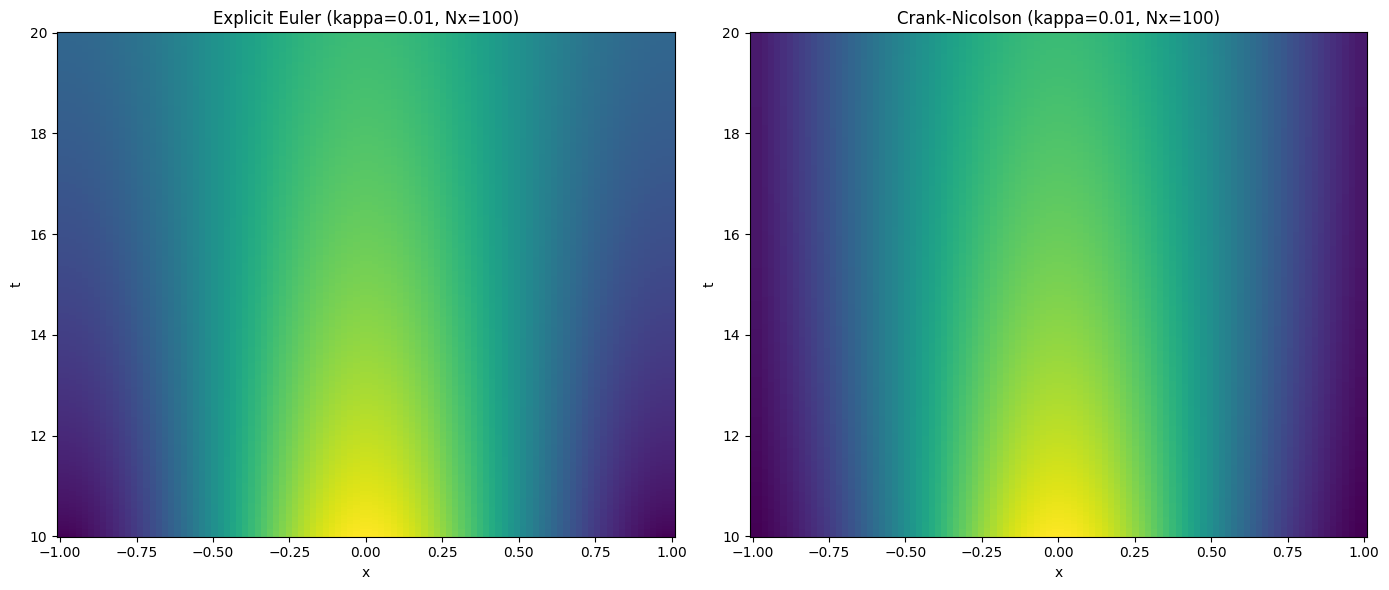

Running simulation with kappa = 0.01, Nx = 200
Explicit Euler method took 0.19 seconds


<ipython-input-3-9171c2f9dd57>:25: RuntimeWarning: invalid value encountered in add
  c[:,k] = c[:,k-1] + dt * kappa * M @ c[:,k-1]


Crank-Nicolson method took 0.23 seconds


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:1370: RuntimeWarning: overflow encountered in subtract
  resdat -= vmin
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:1371: RuntimeWarning: overflow encountered in scalar subtract
  resdat /= (vmax - vmin)
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:1371: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)


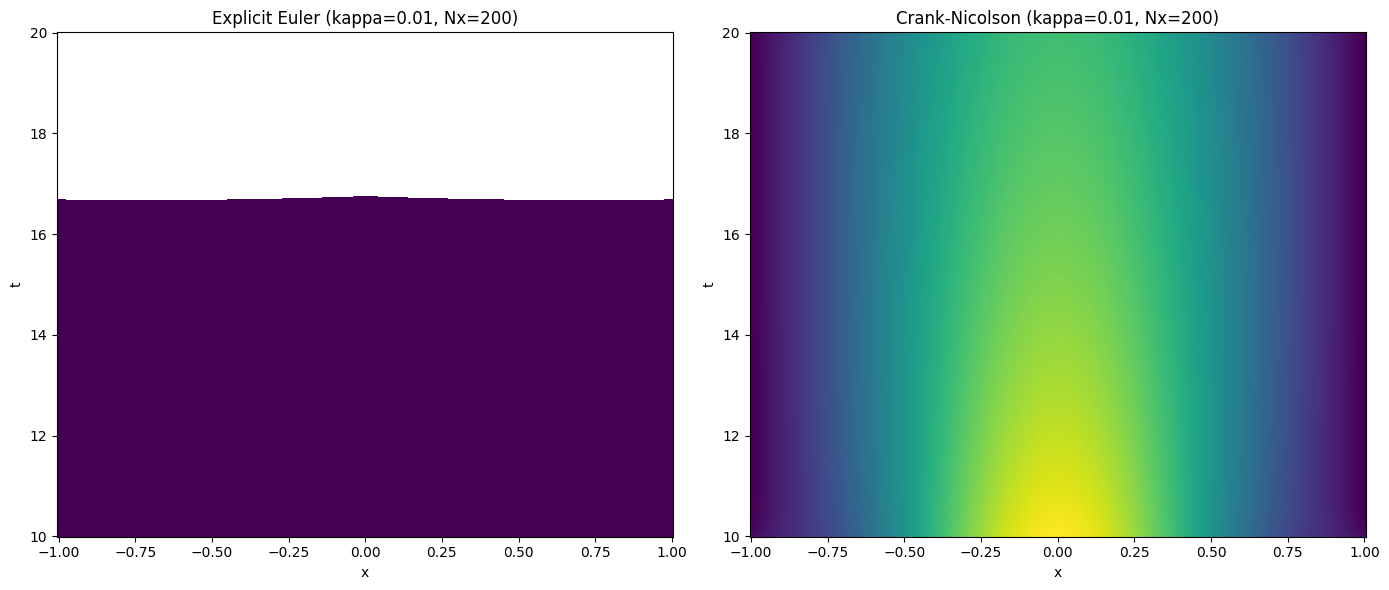

Running simulation with kappa = 0.1, Nx = 50
Explicit Euler method took 0.11 seconds
Crank-Nicolson method took 0.04 seconds


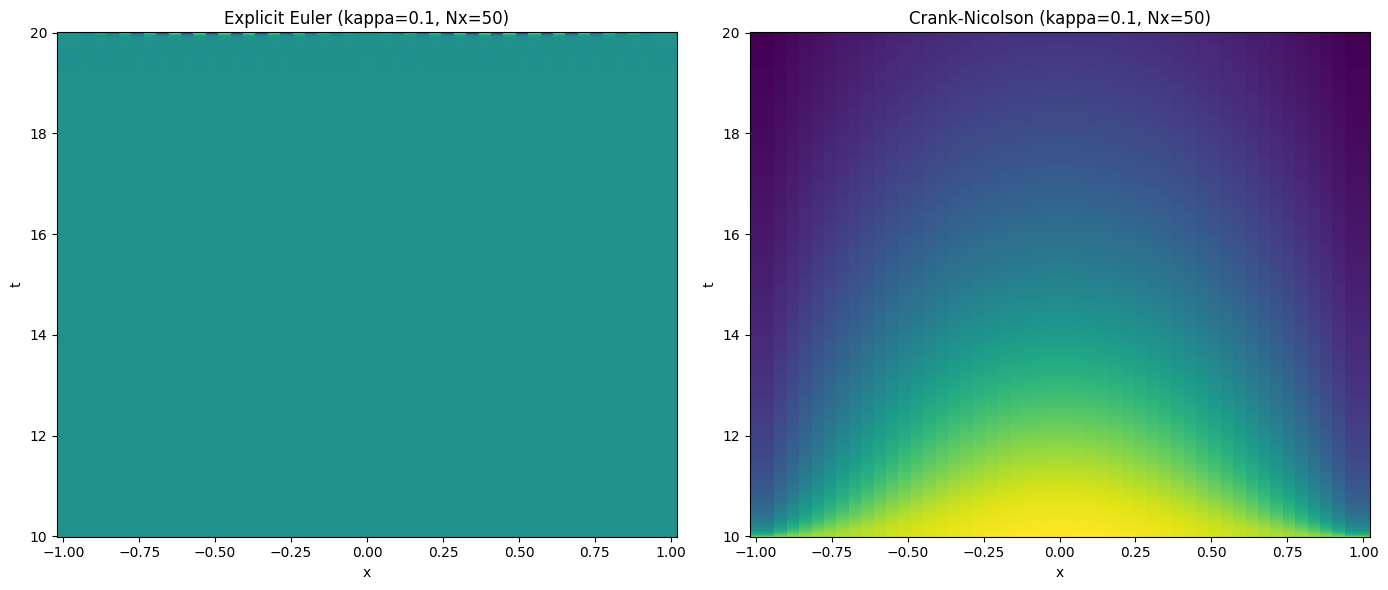

Running simulation with kappa = 0.1, Nx = 100
Explicit Euler method took 0.09 seconds
Crank-Nicolson method took 0.06 seconds


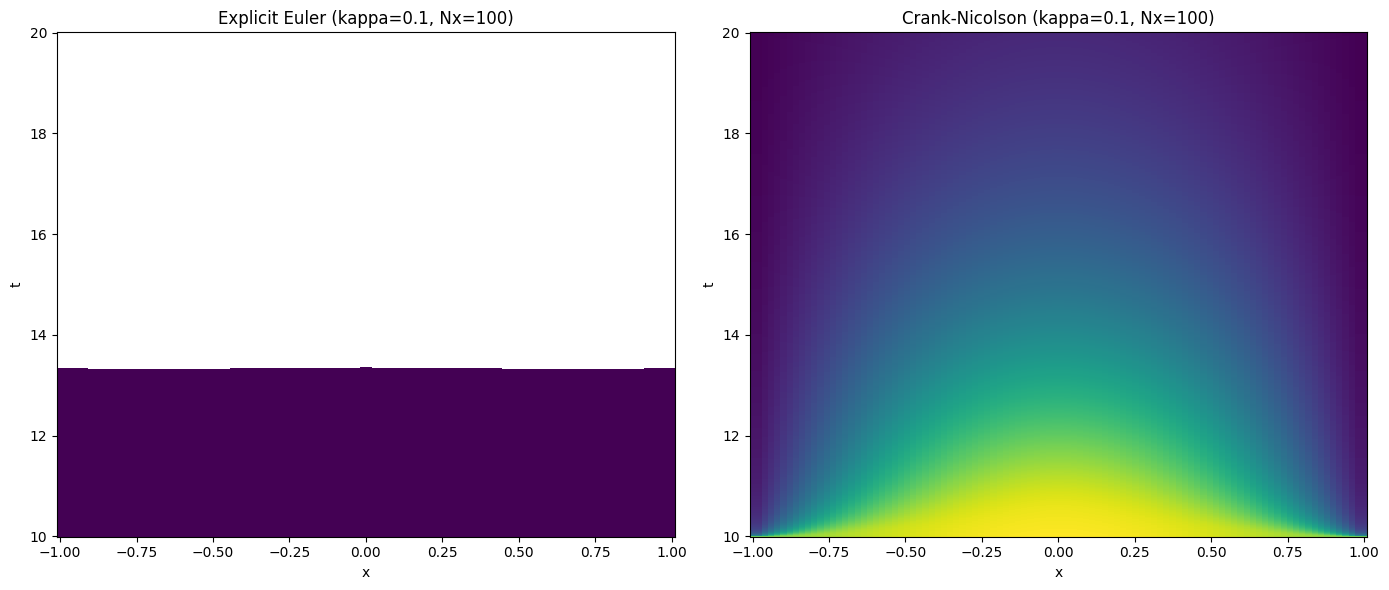

Running simulation with kappa = 0.1, Nx = 200
Explicit Euler method took 0.09 seconds
Crank-Nicolson method took 0.14 seconds


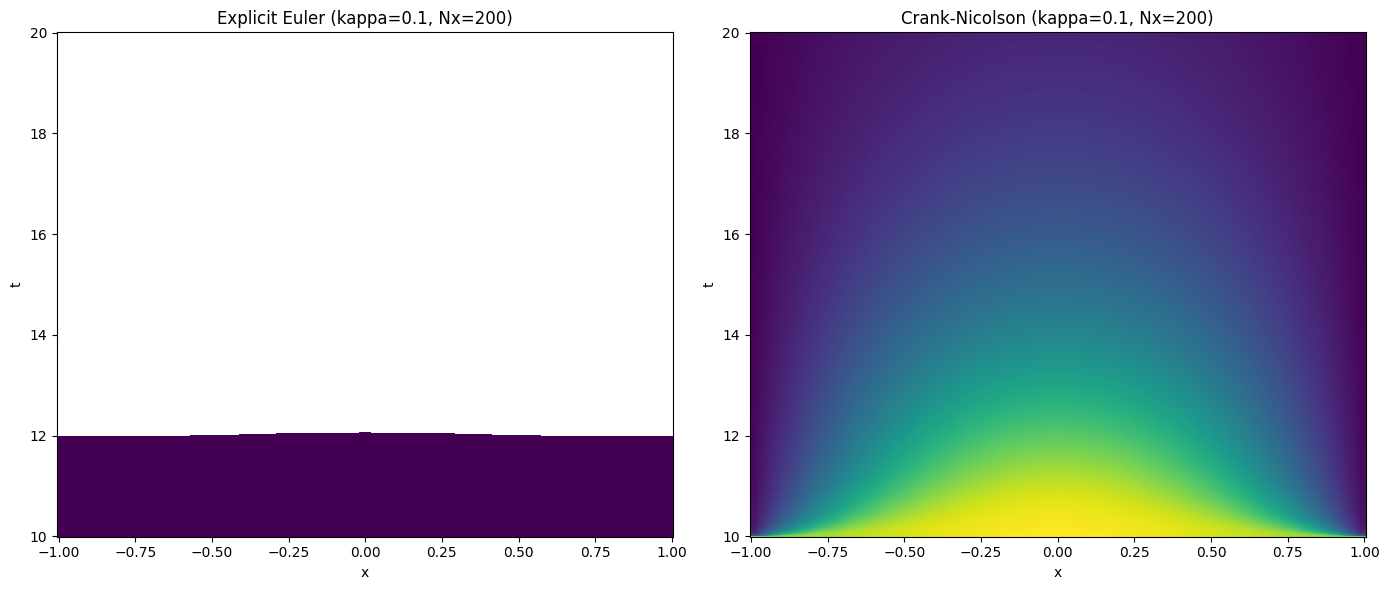

In [9]:
# Defining parameters
kappa_values = [0.001, 0.01, 0.1]  
Nx_values = [50, 100, 200] 

# Timestepping parameters
t_start = 10  
t_end = 20  
Nt = 1000  

# Size of the physical domain
x_start = -1
x_end = 1

# Run each kappa and Nx
for kappa in kappa_values:
  for Nx in Nx_values:
    print(f"kappa = {kappa}, Nx = {Nx}")
    t = np.linspace(t_start, t_end, Nt)  
    x = np.linspace(x_start, x_end, Nx) 
    # Run each method once:
    c_EE = EE(x, t, kappa) 
    c_CN = CN(x, t, kappa) 
    # and finally, plot the results side-by-side
    # Plot the results
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.pcolormesh(x, t, c_EE.T, shading='auto')
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title(f'Explicit Euler (kappa={kappa}, Nx={Nx})')

    plt.subplot(1, 2, 2)
    plt.pcolormesh(x, t, c_CN.T, shading='auto')
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title(f'Crank-Nicolson (kappa={kappa}, Nx={Nx})')

    plt.tight_layout()
    plt.show()

### 2.2 Accuracy
<a id='section2pt2'></a>
Next, we will examine the accuracy of the numerical methods used above. In order to do this, it is useful to compare our numerical solutions with the exact solution to the diffusion equation. Below, write code to plot the exact solution and the numerical solution using explicit Euler and Crank-Nicolson at the final time ($t=10$). Note that you can use the exact solution to the diffusion equation in an unbounded domain in $x$ and keep in mind that the exact solution and numerical solutions will differ for later times when boundary effects are felt.

Explicit Euler method took 0.23 seconds
Crank-Nicolson method took 0.18 seconds
Explicit Euler method took 0.17 seconds
Crank-Nicolson method took 0.10 seconds


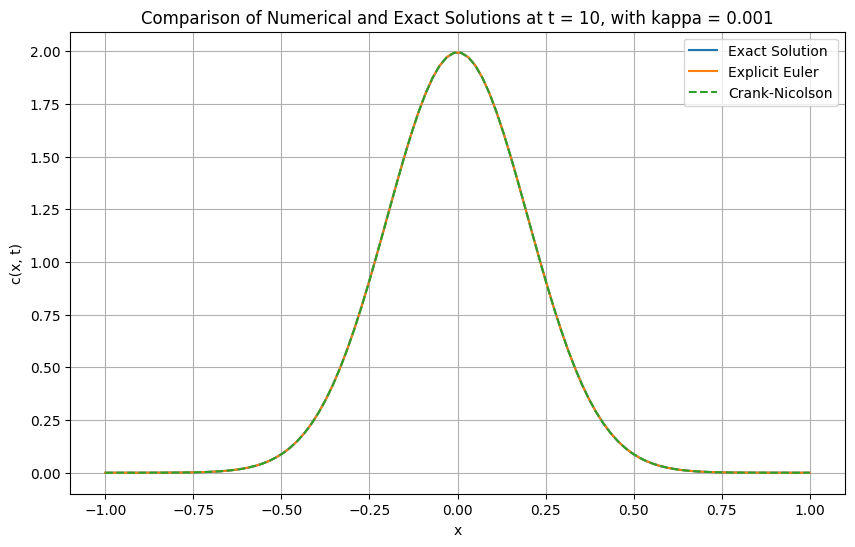

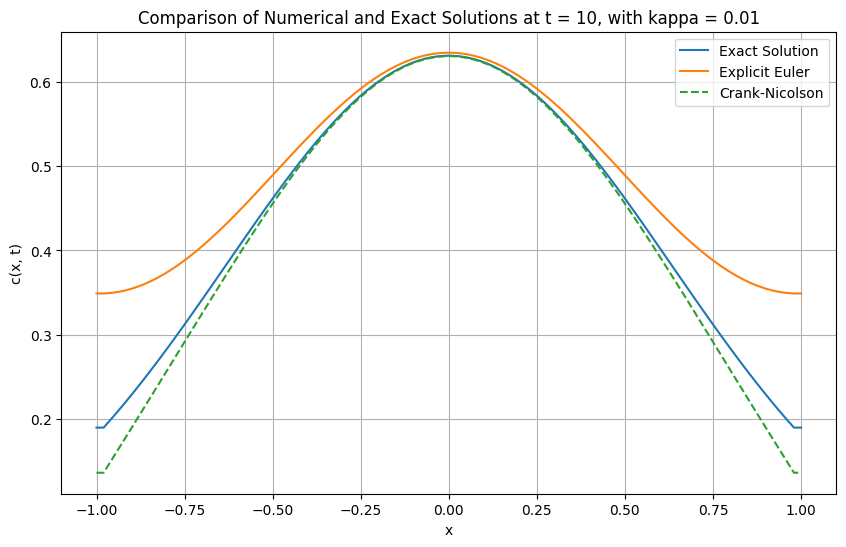

In [23]:
# Given parameters
kappa1 = 0.001
kappa2 = 0.01
t_start = 10
t_end = 20
Nt = 1000
x_start = -1
x_end = 1
Nx = 100

# Create vectors of times and x
t = np.linspace(t_start, t_end, Nt)
x = np.linspace(x_start, x_end, Nx)

# Calculate the exact solution at the final time
c_exact1 = set_ics(x, kappa1, t_end)
c_exact2 = set_ics(x, kappa2, t_end)


# Assuming EE and CN functions return results with dimensions (Nx, Nt)
# Get the numerical solutions 
c_EE1 = EE(x, t, kappa1)  
c_CN1 = CN(x, t, kappa1) 
c_EE2 = EE(x, t, kappa2) 
c_CN2 = CN(x, t, kappa2) 

# Plot the exact and numerical solutions at the final time
plt.figure(figsize=(10, 6))
plt.plot(x, c_exact1, label='Exact Solution')
plt.plot(x, c_EE1[:, -1], label='Explicit Euler')
plt.plot(x, c_CN1[:, -1],'--', label='Crank-Nicolson')
plt.xlabel('x')
plt.ylabel('c(x, t)')
plt.title('Comparison of Numerical and Exact Solutions at t = 10, with kappa = 0.001')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(x, c_exact2, label='Exact Solution')
plt.plot(x, c_EE2[:, -1], label='Explicit Euler')
plt.plot(x, c_CN2[:, -1],'--', label='Crank-Nicolson')
plt.xlabel('x')
plt.ylabel('c(x, t)')
plt.title('Comparison of Numerical and Exact Solutions at t = 10, with kappa = 0.01')
plt.legend()
plt.grid(True)
plt.show()


For $κ=0.001$, the Explicit Euler, Crank-Nicolson, and exact solutions align almost perfectly. Both numerical methods accurately capture the concentration profile, with minimal visible deviation from the exact solution. However, for $κ=0.01$, the Explicit Euler solution shows significant deviations, particularly at the boundary, indicating reduced accuracy at higher diffusivity. In contrast, the Crank-Nicolson solution remains closer to the exact solution, though it slightly underestimates near the boundary. This comparison highlights that while both methods perform well at lower diffusivity, Crank-Nicolson is more robust and accurate for higher diffusion cases.

Now, define a measure of the error of each numerical method compared to the exact solution (there is no single correct way to do this). Plot the error of both methods as a function of the grid spacing $\Delta x$. Then, similarly plot the error as a function of the timestep, $\Delta t$.

To measure the error between the numerical methods and the exact solution, I can choose a standard error metric such as the root mean square error (RMSE) or maximum error. Here, I'll use the RMSE and plot it against the grid spacing
$\Delta x$ and the timestep $\Delta t$.

$$
\text{RMSE} = \sqrt{\frac{1}{N_x} \sum_{i=1}^{N_x} \left( c_{\text{numerical}}(x_i, t_{\text{end}}) - c_{\text{exact}}(x_i, t_{\text{end}}) \right)^2}
$$



Explicit Euler method took 0.00 seconds
Crank-Nicolson method took 0.04 seconds
Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.05 seconds
Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.07 seconds
Explicit Euler method took 0.04 seconds
Crank-Nicolson method took 0.12 seconds
Explicit Euler method took 0.05 seconds
Crank-Nicolson method took 0.20 seconds
Explicit Euler method took 0.05 seconds
Crank-Nicolson method took 0.47 seconds
Explicit Euler method took 0.18 seconds
Crank-Nicolson method took 0.54 seconds
Explicit Euler method took 0.15 seconds
Crank-Nicolson method took 0.67 seconds


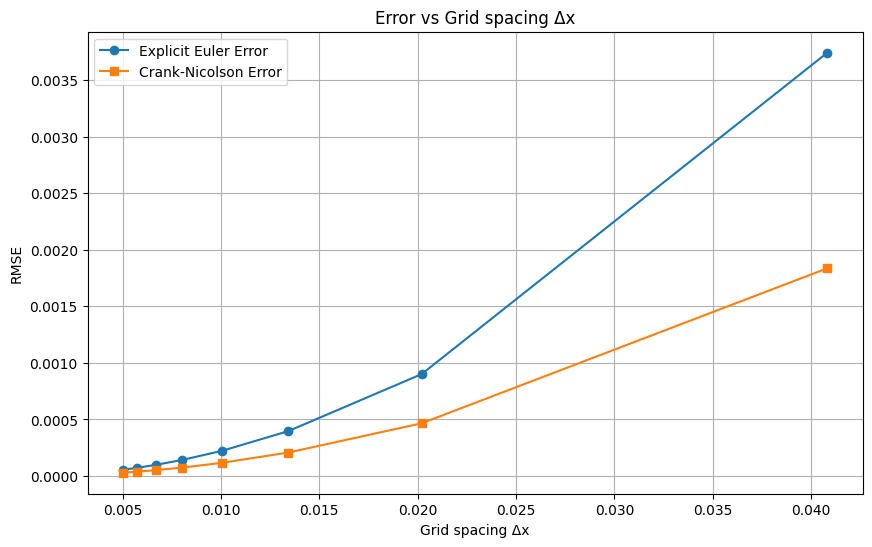

Explicit Euler method took 0.03 seconds
Crank-Nicolson method took 0.10 seconds
Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.05 seconds
Explicit Euler method took 0.02 seconds
Crank-Nicolson method took 0.06 seconds
Explicit Euler method took 0.04 seconds
Crank-Nicolson method took 0.07 seconds
Explicit Euler method took 0.03 seconds
Crank-Nicolson method took 0.07 seconds
Explicit Euler method took 0.04 seconds
Crank-Nicolson method took 0.07 seconds
Explicit Euler method took 0.05 seconds
Crank-Nicolson method took 0.08 seconds
Explicit Euler method took 0.05 seconds
Crank-Nicolson method took 0.08 seconds
Explicit Euler method took 0.06 seconds
Crank-Nicolson method took 0.09 seconds
Explicit Euler method took 0.07 seconds
Crank-Nicolson method took 0.09 seconds
Explicit Euler method took 0.15 seconds
Crank-Nicolson method took 0.15 seconds


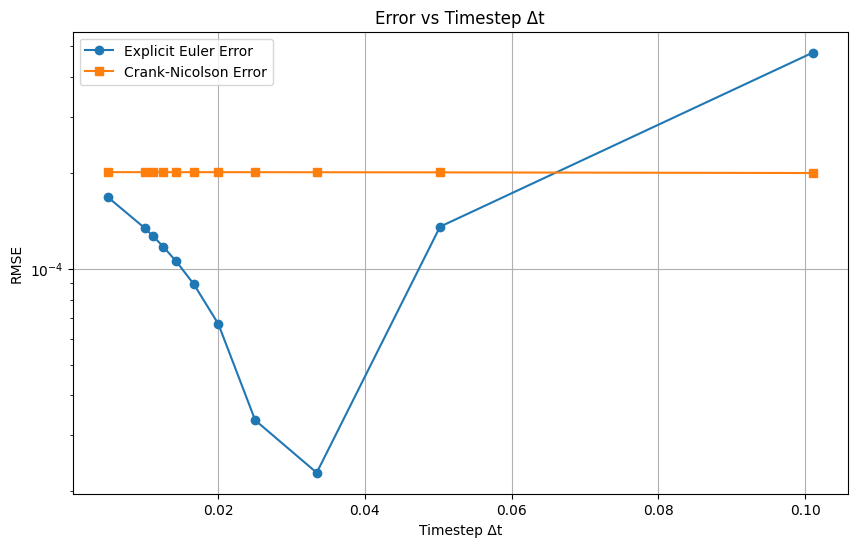

In [40]:
# Define RMSE (root mean square error) calculation
def calculate_rmse(c_numerical, c_exact):
    return np.sqrt(np.mean((c_numerical - c_exact) ** 2))

# Parameters
kappa = 0.001
t_start = 10
t_end = 20
Nt = 1000
x_start = -1
x_end = 1


# Define ranges for grid spacing (Delta x) and timestep (Delta t)
Nx_values = [50,100,150,200,250,300,350,400]
Nt_values = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000]

# Error as a function of Delta x
errors_dx_EE = []
errors_dx_CN = []
dx_values = []

for Nx in Nx_values:
    x = np.linspace(x_start, x_end, Nx)
    t = np.linspace(t_start, t_end, Nt)
    dx = (x_end - x_start) / (Nx - 1)
    dt = 0.5 * (dx * dx) / kappa;
    t = np.arange(t_start, t_end, dt);
    dx_values.append(dx)
    # Calculate the exact solution at the final time
    c_exact = set_ics(x, kappa, t_end)
    # Run numerical methods
    c_EE = EE(x, t, kappa)  
    c_CN = CN(x, t, kappa) 

    # Calculate errors
    error_EE = calculate_rmse(c_EE[:,-1], c_exact)
    error_CN = calculate_rmse(c_CN[:,-1], c_exact)

    errors_dx_EE.append(error_EE)
    errors_dx_CN.append(error_CN)

# Plot error vs Delta x
plt.figure(figsize=(10, 6))
plt.plot(dx_values, errors_dx_EE, label='Explicit Euler Error', marker='o')
plt.plot(dx_values, errors_dx_CN, label='Crank-Nicolson Error', marker='s')
plt.xlabel('Grid spacing Δx')
plt.ylabel('RMSE')
plt.title('Error vs Grid spacing Δx')
plt.legend()
plt.grid(True)
plt.show()

# Error as a function of Delta t
errors_dt_EE = []
errors_dt_CN = []
dt_values = []

for Nt in Nt_values:

    x = np.linspace(x_start, x_end, Nx_values[2])  # Choose a fixed Nx for this part
    dt = (t_end - t_start) / (Nt - 1)
    dt_values.append(dt)
    t = np.linspace(t_start, t_end, Nt)
    # Calculate the exact solution at the final time
    c_exact = set_ics(x, kappa, t_end)

    # Run numerical methods
    c_EE = EE(x, t, kappa)  # Explicit Euler solution
    c_CN = CN(x, t, kappa)  # Crank-Nicolson solution

    # Calculate errors
    error_EE = calculate_rmse(c_EE[:, -1], c_exact)
    error_CN = calculate_rmse(c_CN[:, -1], c_exact)

    errors_dt_EE.append(error_EE)
    errors_dt_CN.append(error_CN)

# Plot error vs Delta t
plt.figure(figsize=(10, 6))
plt.plot(dt_values, errors_dt_EE, label='Explicit Euler Error', marker='o')
plt.plot(dt_values, errors_dt_CN, label='Crank-Nicolson Error', marker='s')
plt.xlabel('Timestep Δt')
plt.ylabel('RMSE')
plt.yscale('log')
plt.title('Error vs Timestep Δt')
plt.legend()
plt.grid(True)
plt.show()


The first plot shows that as grid spacing ($\Delta x$) increases, the RMSE grows for both methods. However, the Crank-Nicolson (CN) method consistently performs better than the Explicit Euler (EE) method, with lower errors across all grid spacings. This highlights the CN method's second-order accuracy in space, which makes it more reliable for coarser grids, while the first-order EE method accumulates significant truncation errors as $\Delta x$ increases.

In contrast, the second plot reveals the difference in stability between the two methods as timestep ($\Delta t$) increases. The CN method seems like maintain a constant, but I print out c_CN, accuturally every time the value is different. I tried to plot the figure solely at below. On the other hand, For the particular grid spacing $Δx$ there is a global minimum, which means at this timestep the simulation performs the best. This indicated the EE method is conditionally stable and becomes unstable at larger $\Delta t$, with errors rapidly diverging when the CFL condition is not hold. 

Crank-Nicolson method took 0.05 seconds
Crank-Nicolson method took 0.06 seconds
Crank-Nicolson method took 0.06 seconds
Crank-Nicolson method took 0.07 seconds
Crank-Nicolson method took 0.09 seconds
Crank-Nicolson method took 0.08 seconds
Crank-Nicolson method took 0.08 seconds
Crank-Nicolson method took 0.10 seconds
Crank-Nicolson method took 0.10 seconds
Crank-Nicolson method took 0.10 seconds
Crank-Nicolson method took 0.21 seconds


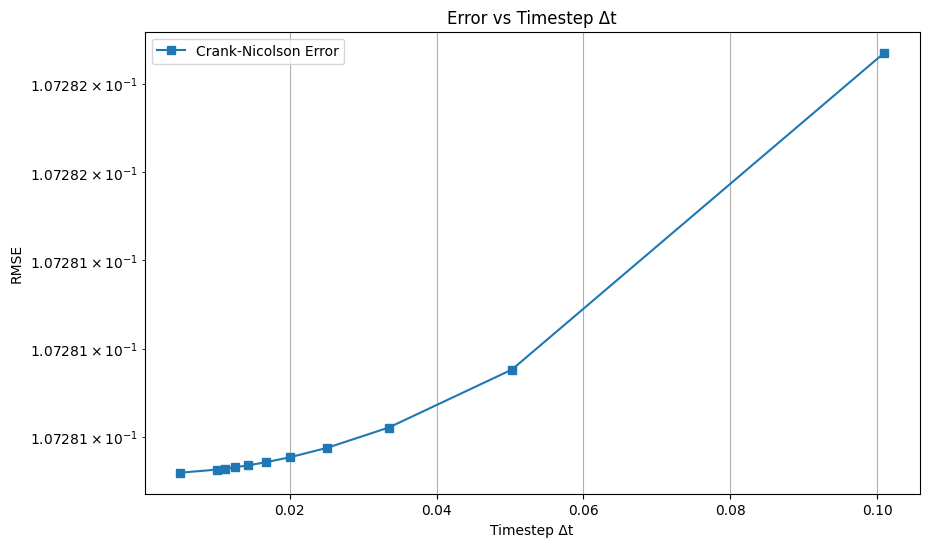

In [38]:
# Define RMSE (root mean square error) calculation
def calculate_rmse(c_numerical, c_exact):
    return np.sqrt(np.mean((c_numerical - c_exact) ** 2))

# Parameters
kappa = 0.001
t_start = 5
t_end = 15
Nt = 1000
x_start = -1
x_end = 1


# Define ranges for grid spacing (Delta x) and timestep (Delta t)
Nx_values = [50,100,150,200,250,300,350,400]
Nt_values = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000]


# Error as a function of Delta t
errors_dt_CN = []
dt_values = []

for Nt in Nt_values:

    x = np.linspace(x_start, x_end, 100)  # Choose a fixed Nx for this part
    dt = (t_end - t_start) / (Nt - 1)
    dt_values.append(dt)
    t = np.linspace(t_start, t_end, Nt)
    # Calculate the exact solution at the final time
    c_exact = set_ics(x, kappa, t_end)

    # Run numerical methods
    #c_EE = EE(x, t, kappa) 
    c_CN = CN(x, t, kappa) 

    # Calculate errors
    #error_EE = calculate_rmse(c_EE[:, -1], c_exact)
    error_CN = calculate_rmse(c_CN[:, -1], c_exact)

    #errors_dt_EE.append(error_EE)
    errors_dt_CN.append(error_CN)

# Plot error vs Delta t
plt.figure(figsize=(10, 6))
#plt.plot(dt_values, errors_dt_EE, label='Explicit Euler Error', marker='o')
plt.plot(dt_values, errors_dt_CN, label='Crank-Nicolson Error', marker='s')
plt.xlabel('Timestep Δt')
plt.ylabel('RMSE')
plt.yscale('log')
plt.title('Error vs Timestep Δt')
plt.legend()
plt.grid(True)
plt.show()


Finally, select a given error tolerance and explore whether explicit Euler or Crank-Nicoslon is more efficient (faster) at generating solutions with error less than your error tolerance. Discuss your conclusion and add supporting figures if necessary.

Explicit Euler method took 0.06 seconds
Explicit Euler method took 0.12 seconds
Explicit Euler method took 0.24 seconds
Explicit Euler method took 0.32 seconds
Explicit Euler method took 0.32 seconds
Explicit Euler method took 0.03 seconds
Explicit Euler method took 0.04 seconds
Explicit Euler method took 0.05 seconds


<ipython-input-17-a5646c4ff3e2>:3: RuntimeWarning: overflow encountered in square
  return np.sqrt(np.mean((c_numerical - c_exact) ** 2))
<ipython-input-3-9171c2f9dd57>:25: RuntimeWarning: invalid value encountered in add
  c[:,k] = c[:,k-1] + dt * kappa * M @ c[:,k-1]


Explicit Euler method took 0.09 seconds
Explicit Euler method took 0.05 seconds
Explicit Euler method took 0.10 seconds
Explicit Euler method took 0.17 seconds
Explicit Euler method took 0.36 seconds
Crank-Nicolson method took 0.02 seconds
Crank-Nicolson method took 0.04 seconds
Crank-Nicolson method took 0.06 seconds
Crank-Nicolson method took 0.10 seconds
Crank-Nicolson method took 0.12 seconds
Crank-Nicolson method took 0.04 seconds
Crank-Nicolson method took 0.17 seconds
Crank-Nicolson method took 0.27 seconds
Crank-Nicolson method took 0.79 seconds
[0.03404831886291504, 0.04129314422607422, 0.08805060386657715, 0.3614635467529297] [0.00032167866338375764, 8.451699380372097e-05, 3.9124229693765236e-05, 9.849508787515303e-06]
[0.042819976806640625, 0.16654658317565918, 0.2657628059387207, 0.7874321937561035] [0.0004554529091675665, 5.0004356972004485e-05, 2.807098554329965e-05, 7.018387918902237e-06]


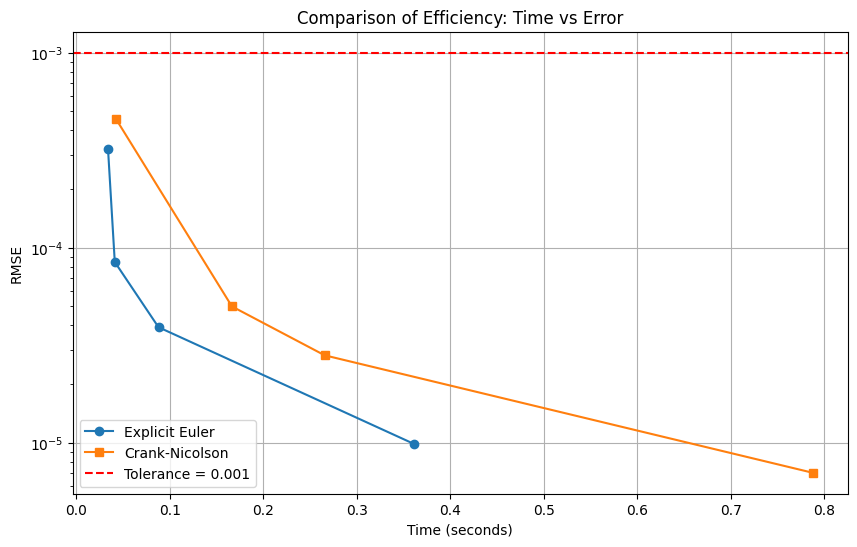

In [17]:
# Define RMSE calculation
def calculate_rmse(c_numerical, c_exact):
    return np.sqrt(np.mean((c_numerical - c_exact) ** 2))

# Parameters
kappa = 0.001
t_start = 10
t_end = 20
Nx_values = [50, 100, 300, 400, 800]  # Different grid points (for varying Δx)
Nt_values = [500, 1000, 2000, 4000,5000]  # Different timesteps (for varying Δt)
tolerance = 0.001 # Error tolerance

# Function to test efficiency of each method
def measure_efficiency(method_name, kappa, tolerance):
    times_in = []
    errors_in = []

    times_out = []
    errors_out = []

    for Nx in Nx_values:
        for Nt in Nt_values:
            # Create vectors of x and t
            x = np.linspace(-1, 1, Nx)
            t = np.linspace(t_start, t_end, Nt)

            # Calculate the exact solution at the final time
            c_exact = set_ics(x, kappa, t_end)

            # Run the selected numerical method and measure runtime
            start_time = time.time()

            if method_name == 'Explicit Euler':
                c_numerical = EE(x, t, kappa)  
            elif method_name == 'Crank-Nicolson':
                c_numerical = CN(x, t, kappa) 

            runtime = time.time() - start_time

            # Calculate the RMSE
            error = calculate_rmse(c_numerical[:, -1], c_exact)

            # Store results if error is below tolerance
            if error < tolerance:
                times_in.append(runtime)
                errors_in.append(error)
                break  # Exit the loop as soon as we achieve the required error
            else:
                # Record the error and time even if it doesn't meet tolerance
                times_out.append(runtime)
                errors_out.append(error)

    return times_in, errors_in

# Measure efficiency for each method
times_EE, errors_EE = measure_efficiency('Explicit Euler', kappa, tolerance)
times_CN, errors_CN = measure_efficiency('Crank-Nicolson', kappa, tolerance)
print(times_EE, errors_EE)
print(times_CN, errors_CN)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(times_EE, errors_EE, marker='o', label='Explicit Euler')
plt.plot(times_CN, errors_CN, marker='s', label='Crank-Nicolson')
plt.axhline(y=tolerance, color='r',  linestyle='--', label=f'Tolerance = {tolerance}')
plt.xlabel('Time (seconds)')
plt.ylabel('RMSE')
plt.yscale ('log')
plt.title('Comparison of Efficiency: Time vs Error')
plt.legend()
plt.grid(True)
plt.show()


The Explicit Euler method is faster than the Crank-Nicolson method. An intuitive explanation is that the Explicit Euler method only relies on a single previous $x$ value for its calculations. In contrast, the Crank-Nicolson method involves two $x$ values, requiring more computational effort. Consequently, the Crank-Nicolson method is slower.

Each method has clear advantages and disadvantages. The Explicit Euler method is faster but lacks stability, making it conditionally reliable. On the other hand, the Crank-Nicolson method is more stable and robust, but it is computationally less efficient.


Now, move to Project1_dedalus.ipynb which will introduce Dedalus and spectral methods.

### 3. Optional further investigations

The application of the boundary conditions for the Crank-Nicolson method isn't quite right in the script above (but the boundary conditions aren't very important in this example). Account for the boundary conditions by modifying the coefficient matrix. This ensures that the boundary conditions are applied to the implicit and explicit terms involved in the Crank-Nicolson update. How would you handle fixed value (Dirichlet) and fixed gradient (Neumann) boundary conditions?